<a href="https://colab.research.google.com/github/DorcasO/DorcasO/blob/main/New_CambridgeChatbotAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step1: Mount Google Drive To save our scraped data persistently, we mount Google Drive to access its file system from Colab.


In [21]:
import os

#Define path inside your Google Drive
drive_path = "/content/drive/MyDrive/AMDARI/Cambridge_scraped_data"

# Create the folder if it doesn't exist
os.makedirs(drive_path, exist_ok=True)

Step 2: Create Output Folder. We define the path to a folder named Knowledgebase_data inside your Google Drive. If the folder doesn't exist, we create it using os.makedirs().

In [22]:
#Create the folder if it doesn't exist
os.makedirs(drive_path, exist_ok=True)

Install core libraries

In [23]:
pip install -q transformers sentence-transformers faiss-cpu langchain gradio chromadb qdrant-client

In [4]:
pip install -U langchain-community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.9 MB/s eta 0:00:00


In [24]:
pip install requests beautifulsoup4

In [26]:
import requests
from bs4 import BeautifulSoup
import os

In [27]:
#Define Target Pages
pages = {
    "undergraduate_courses": "https://www.undergraduate.study.cam.ac.uk/courses",
    "fees_and_funding": "https://www.cambridgestudents.cam.ac.uk/fees-and-funding/fees",
    "colleges_and_departments": "https://www.cam.ac.uk/colleges-and-departments/college-a-z",
    "admin":"https://www.afpa.admin.cam.ac.uk/",
    "fees_and_finance":"https://www.undergraduate.study.cam.ac.uk/fees-and-finance",
    "living_costs":"https://www.undergraduate.study.cam.ac.uk/fees-and-finance/living-costs",
    "international_fees_and_costs":"https://www.undergraduate.study.cam.ac.uk/international-students/international-fees-and-costs",
    "finance_and_support":"https://www.undergraduate.study.cam.ac.uk/finance_and_support",
    "entry_requirements":"https://www.undergraduate.study.com/entry-requirements",
    "application_process":"https://www.undergraduate.study.com/application-process",
    "student_life":"https://www.undergraduate.study.cam.ac.uk/student-life",
    "events_open_days":"https://www.undergraduate.study.cam.ac.uk/events-open-days",
    "news":"https://www.undergraduate.study.cam.ac.uk/news",
    "research":"https://www.undergraduate.study.cam.ac.uk/research",
    "careers":"https://www.undergraduate.study.cam.ac.uk/careers",
    "about_us":"https://www.undergraduate.study.cam.ac.uk/about-us",
    "contact_us":"https://www.undergraduate.study.cam.ac.uk/contact-us"
}

Step 5: Web Scraping Function This function:

Sends a GET request to the given URL Parses HTML using BeautifulSoup Extracts the page title and all paragraphs (

) Returns them as a list of strings

In [28]:
def scrape_page(url):
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')

        title = soup.title.text.strip() if soup.title else "No Title"
        paragraphs = [p.text.strip() for p in soup.find_all("p") if p.text.strip()]
        return title, paragraphs
    except Exception as e:
        print(f"Error scraping {url}: {e}")
        return "Error", []

Step 6: Save Data as Markdown File This function:

Combines the scraped title and content into markdown format Saves the file inside your Google Drive folder as filename.md

In [29]:
def save_to_markdown(title, paragraphs, filename):
    filepath = os.path.join(drive_path, f"{filename}.md")
    with open(filepath, "w", encoding="utf-8") as f:
        f.write(f"# {title}\n\n")
        for para in paragraphs:
            f.write(f"{para}\n\n")
    print(f"✅ Saved to: {filepath}")

Step 7: Loop Through Pages and Save Results For each page in our list:

Scrape the content using scrape_page() Save it as a .md file using save_to_markdown()

In [30]:
for filename, url in pages.items():
    print(f"Scraping: {url}")
    title, content = scrape_page(url)
    save_to_markdown(title, content, filename)


Scraping: https://www.undergraduate.study.cam.ac.uk/courses
✅ Saved to: /content/drive/MyDrive/AMDARI/Cambridge_scraped_data/undergraduate_courses.md
Scraping: https://www.cambridgestudents.cam.ac.uk/fees-and-funding/fees
✅ Saved to: /content/drive/MyDrive/AMDARI/Cambridge_scraped_data/fees_and_funding.md
Scraping: https://www.cam.ac.uk/colleges-and-departments/college-a-z
✅ Saved to: /content/drive/MyDrive/AMDARI/Cambridge_scraped_data/colleges_and_departments.md
Scraping: https://www.afpa.admin.cam.ac.uk/
✅ Saved to: /content/drive/MyDrive/AMDARI/Cambridge_scraped_data/admin.md
Scraping: https://www.undergraduate.study.cam.ac.uk/fees-and-finance
✅ Saved to: /content/drive/MyDrive/AMDARI/Cambridge_scraped_data/fees_and_finance.md
Scraping: https://www.undergraduate.study.cam.ac.uk/fees-and-finance/living-costs
✅ Saved to: /content/drive/MyDrive/AMDARI/Cambridge_scraped_data/living_costs.md
Scraping: https://www.undergraduate.study.cam.ac.uk/international-students/international-fees-an

In [31]:
import os
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
KB_PATH = "/content/drive/MyDrive/AMDARI/Cambridge_scraped_data"

files = [os.path.join(KB_PATH, f) for dp, _, fn in os.walk(KB_PATH) for f in fn if f.endswith(".md")]
docs = [doc for f in files for doc in TextLoader(f, encoding="utf-8").load()]

text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
chunks = text_splitter.split_documents(docs)
texts = [chunk.page_content for chunk in chunks]
print(f" {len(chunks)} chunks generated.")


 66 chunks generated.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

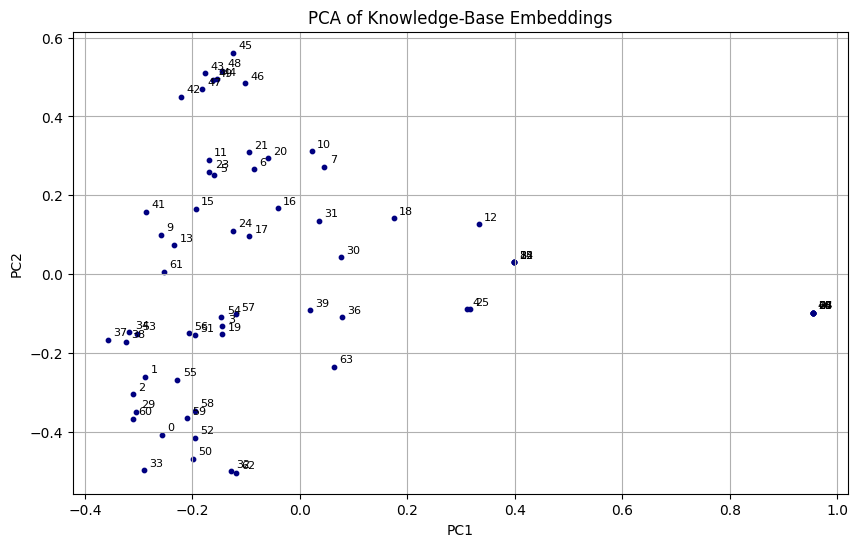

In [32]:
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# 1. Embed all chunks
embed_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
texts = [chunk.page_content for chunk in  chunks]
embeddings = embed_model.encode(texts, show_progress_bar=True)

# 2. PCA to 2 dimensions
pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)

#3. Plot
plt.figure(figsize=(10, 6))
for i, (x,y) in enumerate(reduced):
  plt.scatter(x, y, s=10, c="navy")
  plt.text(x + 0.01, y + 0.01, str(i), fontsize=8)
plt.title("PCA of Knowledge-Base Embeddings")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

In [33]:
import faiss
from langchain.vectorstores import FAISS as LangChainFAISS
from langchain.docstore import InMemoryDocstore
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.schema import Document

# 1. Raw FAISS index
dim = embeddings.shape[1]
faiss_index = faiss.IndexFlatL2(dim)
faiss_index.add(np.array(embeddings, dtype="float32"))

# 2. Prepare LangChain wrapper
docs = [Document(page_content=t) for t in texts]
docstore = InMemoryDocstore({str(i): docs[i] for i in range(len(docs))})
id_map = {i: str(i) for i in range(len(docs))}
embed_fn = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

vectorstore_faiss = LangChainFAISS(
    index=faiss_index,
    docstore=docstore,
    index_to_docstore_id=id_map,
    embedding_function=embed_fn
)

print("  FAISS vectorstore ready.")

/tmp/ipython-input-33-2577777517.py:16: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embed_fn = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")


  FAISS vectorstore ready.


In [34]:
query = "what is Cambridge University about?"
results = vectorstore_faiss.similarity_search(query, k=3)

print("Top-3 FAISS Results:")
for i, doc in enumerate(results):
  print(f"\n- Passage {i+1}:\n{doc.page_content[:300]}...")


Top-3 FAISS Results:

- Passage 1:
The opportunities at Cambridge are like no other – from participating in clubs and societies to finding your way around College and learning to live independently. Most of all, the chance to study a subject you love while surrounded by students and academics who are just as passionate about it as yo...

- Passage 2:
# College A-Z | University of Cambridge

Colleges and Departments

The University of Cambridge has 31 Colleges. All undergraduate students at Cambridge join a College where they live, eat and socialise.

The Colleges provide academic and pastoral support to undergraduates and postgraduates. Each Col...

- Passage 3:
# Student life at Cambridge | Undergraduate Study

Undergraduate Study

Cambridge is a great place to be a student. There’s loads going on in the University, the Colleges and the city.

As a Cambridge student you:

At Cambridge you'll be offered a world-class education, as well as an exceptional stu...


In [35]:
import chromadb
from chromadb.config import Settings
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

# 1. Initialize persistent client (will create 'chroma_data/' locally)
client = chromadb.PersistentClient(
    path="chroma_data",
    settings=Settings()
)

# 2. Create or load a collection named "Cambridge University"
collection = client.get_or_create_collection(
    name="CambridgeUniversity",
    embedding_function=SentenceTransformerEmbeddingFunction(
        model_name="sentence-transformers/all-MiniLM-L6-V2"
    )
)

# 3. Upsert your chunks (ids + documents)
ids = [str(i) for i in range(len(texts))]
collection.upsert(
    documents=texts,
    ids=ids
)
# 4. Query for top-3 similar passages

query = "What is Cambridge University about?"
resp = collection.query(
    query_texts=[query],
    n_results=3
)
print("Top-3 ChromaDB Results:")
for doc in resp["documents"][0]:
    print("-", doc[:200].replace("\n"," "), "...")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Top-3 ChromaDB Results:
- The opportunities at Cambridge are like no other – from participating in clubs and societies to finding your way around College and learning to live independently. Most of all, the chance to study a s ...
- # College A-Z | University of Cambridge  Colleges and Departments  The University of Cambridge has 31 Colleges. All undergraduate students at Cambridge join a College where they live, eat and socialis ...
- # Student life at Cambridge | Undergraduate Study  Undergraduate Study  Cambridge is a great place to be a student. There’s loads going on in the University, the Colleges and the city.  As a Cambridge ...


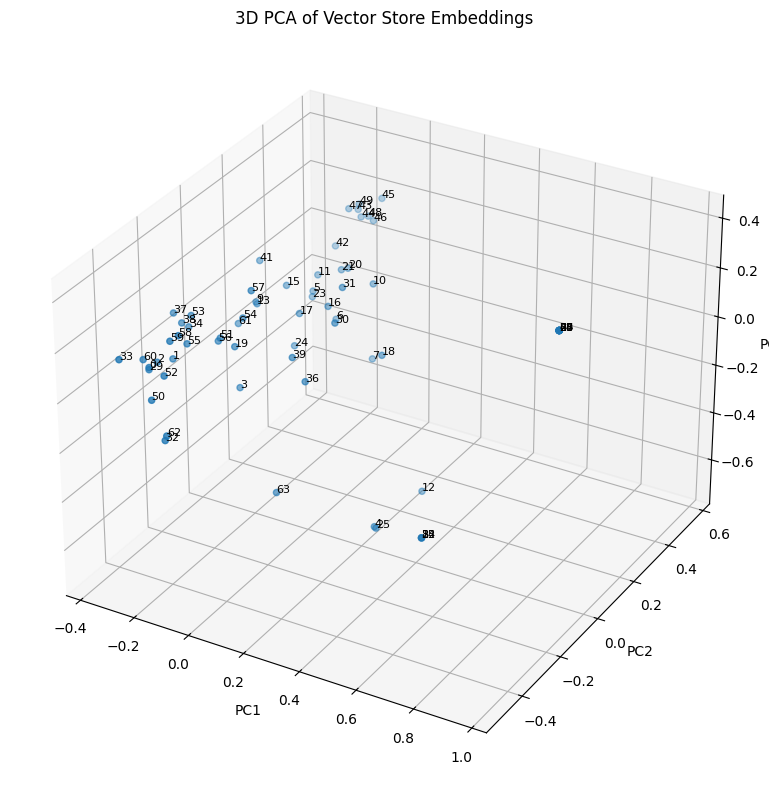

In [36]:
# 3D PCA Visualization of Your Vector Store Embeddings

from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 1. Extract FAISS index
faiss_idx = vectorstore_faiss.index
n = faiss_idx.ntotal

# 2. Reconstruct all vectors
emb_arr = np.vstack([faiss_idx.reconstruct(i) for i in range(n)])

# 3. Reduce to 3D
pca3 = PCA(n_components=3)
embeddings_3d = pca3.fit_transform(emb_arr)

# 4. Plot in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
xs, ys, zs = embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2]
ax.scatter(xs, ys, zs)

# Annotate each point with its index
for i in range(n):
    ax.text(xs[i], ys[i], zs[i], str(i), fontsize=8)

ax.set_title("3D PCA of Vector Store Embeddings")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.tight_layout()
plt.show()

In [40]:
# Install dependencies
!pip install -q transformers sentence-transformers faiss-cpu langchain gradio
!pip install -q -U langchain-community

In [41]:
#Block 1: Install Dependencies & Mount Google Drive Before anything else, we need to set up our environment:

#Install Libraries
#transformers: for loading and running the Falcon-E-1B language model
#sentence-transformers: for generating vector embeddings from text
#faiss-cpu: for building an in-memory vector index for similarity search
#langchain: to orchestrate retrieval-augmented-generation (RAG) pipelines
#gradio: to create a simple web interface for our QA system

In [44]:
import os
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

KB_PATH = "/content/drive/MyDrive/AMDARI/Cambridge_scraped_data"

files = [os.path.join(dp, f) for dp, _, fn in os.walk(KB_PATH) for f in fn if f.endswith(".md")]
docs = [doc for f in files for doc in TextLoader(f, encoding="utf-8").load()]

splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
chunks = splitter.split_documents(docs)
texts = [chunk.page_content for chunk in chunks]
print(f"✅ {len(chunks)} chunks generated.")

✅ 66 chunks generated.


"/content/drive/MyDrive/AMDARI/Cambridge_scraped_data"

### Block 2: Load & Chunk the Markdown Knowledge Base

Now that our files are accessible, we:

1. **Scan the Drive folder** `/content/drive/MyDrive/AMDARI/Cambridge_scraped_data` for all `.md` files.  
2. **Load each Markdown document** with LangChain’s `TextLoader`, turning raw text into `Document` objects.  
3. **Split long documents** into ~500-token chunks with some overlap using `RecursiveCharacterTextSplitter`.  

Why chunk? Smaller passages give more precise semantic matches during retrieval and avoid overwhelming the model with too much context at once.

---

In [ ]:
"/content/drive/MyDrive/AMDARI/Cambridge_scraped_data"

In [45]:
from sentence_transformers import SentenceTransformer
import faiss, numpy as np
from langchain.vectorstores import FAISS as LangChainFAISS
from langchain.docstore import InMemoryDocstore
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.schema import Document

# 1. Generate embeddings
embed_model_id = "sentence-transformers/all-MiniLM-L6-v2"
embedder = SentenceTransformer(embed_model_id)
embeddings = embedder.encode(texts, show_progress_bar=True)

# 2. Build raw FAISS index
dim = embeddings.shape[1]
index = faiss.IndexFlatL2(dim)
index.add(np.array(embeddings, dtype="float32"))

# 3. Wrap in LangChain FAISS
docs = [Document(page_content=t) for t in texts]
docstore = InMemoryDocstore({str(i): docs[i] for i in range(len(docs))})
id_map = {i: str(i) for i in range(len(docs))}
embed_fn = HuggingFaceEmbeddings(model_name=embed_model_id)

vectorstore_faiss = LangChainFAISS(
    index=index,
    docstore=docstore,
    index_to_docstore_id=id_map,
    embedding_function=embed_fn
)

print("✅ FAISS vectorstore is ready.")


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

✅ FAISS vectorstore is ready.


In [42]:
#Block 3: Generate Embeddings & Build the FAISS Vectorstore With text chunks in hand, we:

#Embed every chunk into a high-dimensional vector using the all-MiniLM-L6-v2 sentence transformer.
#Create a FAISS flat L2 index (IndexFlatL2) and add all chunk embeddings—this lets us do lightning-fast nearest-neighbor searches.
#Wrap the FAISS index in LangChain’s FAISS class, linking each vector back to its original text chunk for easy retrieval.
#At the end of this cell, we have a fully functional vector database ready to answer semantic similarity queries.

Block 4: Load all-MiniLM-L6-v2 & Define the Retrieval + Generation Function
This is the heart of our RAG pipeline:

Load the  model="google/flan-t5-large" & tokenizer from Drive (so we don’t re-download every run) and move it to GPU.
Create a HuggingFace text-generation pipeline with controlled settings (no sampling, limited token output).
Wrap that pipeline in LangChain’s HuggingFacePipeline to treat it like an LLM.
Define answer_fn(question):
Retrieve the top 3 most semantically relevant chunks from our FAISS vectorstore.
Build a prompt that tells Falcon to answer only from those chunks (or admit “I don’t know”).
Generate the answer and trim any extra lines.
This function glues retrieval (vector search) and generation (LLM) together into one call.

In [43]:
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
from langchain.vectorstores import Chroma
from langchain.embeddings import SentenceTransformerEmbeddings
from langchain.schema import Document
from langchain.llms import HuggingFacePipeline
from transformers import pipeline

In [53]:
# === Load Chroma DB ===
embedding_model = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")
vectorstore = Chroma(
    persist_directory="course_chroma_db", ### change this to your chroma database
    embedding_function=embedding_model
)

# === Custom Prompt ===
custom_prompt_template = """
You are a helpful assistant for a UK university course advisor chatbot.

You must answer questions using ONLY the context provided below.
If the answer is not in the context, respond with: "I don’t know based on the information available."

Context:
{context}

Question:
{question}

Answer:
"""

prompt = PromptTemplate(
    input_variables=["context", "question"],
    template=custom_prompt_template,
)

# === Load Small LLM ===
llm_pipeline = pipeline(
    "text2text-generation",
    model="google/flan-t5-large", ### you can start with "google/flan-t5-base"
    max_length=512,
    temperature=0.0
)

llm = HuggingFacePipeline(pipeline=llm_pipeline)

# === Function to Filter by Course + Shared ===
def get_filtered_retriever(selected_course):
    return vectorstore.as_retriever(
        search_kwargs={
            "k": 5,
            "filter": {
                "course": {"$in": [selected_course.lower(), "General Info"]}
            }
        }
    )
# === Create RetrievalQA chain for a specific course ===
def get_qa_chain_for_course(course_name):
    retriever = get_filtered_retriever(course_name) # Use the helper function to get the retriever with filter
    return RetrievalQA.from_chain_type(
        llm=llm,
        retriever=retriever,
        chain_type="stuff",
        chain_type_kwargs={"prompt": prompt},
        return_source_documents=True
    )

Device set to use cpu
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


In [55]:
qa_chain = get_qa_chain_for_course("MSc Advanced Computer Science")
query = "How much is the tuition fee?"
result = qa_chain.invoke({"query": query})
print(result['result'])

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


I don’t know based on the information available.


In [56]:
qa_chain = get_qa_chain_for_course("Law (BA)")
query = "What is the admission requirement?"
result = qa_chain.invoke({"query": query})
print(result['result'])

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


I don’t know based on the information available.


In [58]:
qa_chain = get_qa_chain_for_course("undergraduate")
query = "When was the University of Cambridge founded?"
result = qa_chain.invoke({"query": query})
print(result['result'])

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


I don’t know


In [60]:
qa_chain = get_qa_chain_for_course("undergraduate")
query = "How much is the tuition fee for undergraduate courses?"
result = qa_chain.invoke({"query": query})
print(result['result'])

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


I don’t know based on the information available.


cambridge_chatbot_gradio_flan

In [61]:
import gradio as gr
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.chains import RetrievalQA
from langchain.llms import HuggingFacePipeline



In [65]:
# Define the chatbot function for Gradio
def cambridge_chatbot(query):
    # Assuming 'qa_chain' is already defined and initialized
    # The qa_chain.invoke({'query': query}) method returns a dictionary
    # with at least a 'result' key containing the answer.
    result = qa_chain.invoke({"query": query})
    return result.get('result', 'I don’t know based on the information available.')

# Gradio Interface
demo = gr.Interface(
    fn=cambridge_chatbot,
    inputs=gr.Textbox(lines=2, placeholder="Ask a question about Cambridge University..."),
    outputs="text",
    title="Cambridge University Advisor Chatbot",
    description="Ask anything about Cambridge University.",
    theme="default"
)

# To run the Gradio interface, you would typically add:
# demo.launch()
# in a separate cell or after the interface definition if not in Colab.
# In Colab, demo.launch() will automatically start the interface when the cell is run.

In [63]:
qa_chain = get_qa_chain_for_course("MSc Advanced Computer Science")
query = "How much is the tuition fee?"
result = qa_chain.invoke({"query": query})
print(result['result'])

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


I don’t know based on the information available.


In [66]:
qa_chain = get_qa_chain_for_course("Undergraduate Study")
query = "How much is the living cost fee?"
result = qa_chain.invoke({"query": query})
print(result['result'])

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


I don’t know based on the information available.


In [ ]:
demo.launch(debug=True)

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://8a4386823e58fe7a61.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
